# Рынок заведений общественного питания Москвы

 В Москве планируется открытие нового кафе с оригинальной идеей — гостей должны обслуживать роботы. Проект дорогой и необходимо обратиться к инвесторам. Их интересует текущее положение дел на рынке — насколько продолжительно будет популярно данное заведение?
Требуется подготовить исследование рынка исходя из открытых данных о заведениях общественного питания в Москве.

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from plotly import graph_objects as go
import requests
import re
import json

In [2]:
rest = pd.read_csv('/datasets/rest_data.csv')

In [3]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
rest.head(5)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [5]:
#Приведем к нижнему регистру названия заведений и адреса
rest['object_name'] = rest['object_name'].str.lower()
rest['object_type'] = rest['object_type'].str.lower()
rest['address'] = rest['address'].str.lower()

In [6]:
# проверим на дубликаты
rest.duplicated().sum()

0

In [7]:
np.unique(rest[['chain']].values)

array(['да', 'нет'], dtype=object)

In [8]:
np.unique(rest[['object_type']].values)

array(['бар', 'буфет', 'закусочная', 'кафе', 'кафетерий',
       'магазин (отдел кулинарии)', 'предприятие быстрого обслуживания',
       'ресторан', 'столовая'], dtype=object)

In [9]:
#длинные названия заменим на ёмкие
rest['object_type']=rest['object_type'].str.replace('магазин \(отдел кулинарии\)', 'кулинария')
rest['object_type']=rest['object_type'].str.replace('предприятие быстрого обслуживания', 'фастфуд')

Таблица rest_data:

- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

Данные полные, дубликаты отсутствуют.

### Анализ данных

#### Исследуем соотношение видов объектов общественного питания по количеству. Построим график

In [10]:
#сгруппируем таблицу по видам объектов и посчитаем их колличество
count_type=rest.groupby('object_type').count().reset_index()

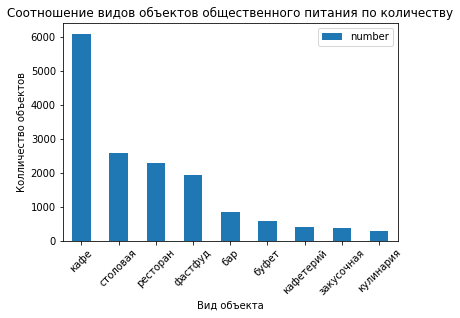

In [11]:
#изобразим графически
count_type[['object_type', 'number']].set_index('object_type').sort_values('number', ascending=False).plot(kind='bar')
plt.xlabel('Вид объекта')
plt.ylabel('Колличество объектов')
plt.title('Cоотношение видов объектов общественного питания по количеству')
plt.xticks(rotation=45)
plt.show();

In [12]:
rest.groupby('object_type')['object_name'].count().sort_values()

object_type
кулинария      273
закусочная     360
кафетерий      398
буфет          585
бар            856
фастфуд       1923
ресторан      2285
столовая      2587
кафе          6099
Name: object_name, dtype: int64

Если рассматривать по типу заведений общественного питания, то привалирует кафе. Что удивительно на втором месте по популярности идут столовая, ресторан и фастфуд, хотя по колличеству их в 2-2,5 раза меньше чем кафе. Меньше всего в городе есть кулинарий и закусочных.

#### Исследуем соотношение сетевых и несетевых заведений по количеству. Построим график

In [13]:
#построим таблицу где посчитаем сколько сетевых и несетевых заведений
count_set=rest.groupby('chain')['object_name'].count().reset_index()
count_set

,chain,object_name
0,да,2968
1,нет,12398


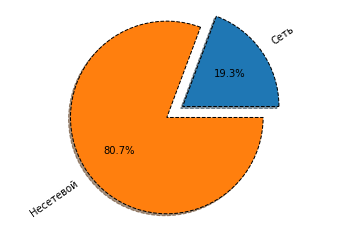

In [14]:
# рассмотрим их соотношение графически
vals = [2968, 12398]
labels = ["Сеть", "Несетевой"]
explode = (0.2, 0)
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode,\
       wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal");

Несмотря на кажущееся огромное колличество сетевых заведений в Москве,их колличество в 4 раза меньше иных заведений, обслуживающих население города

#### Для какого вида объекта общественного питания характерно сетевое распространение?

In [15]:
#построим таблицу с расчетами по объектам заведений-сетевики и несетевики
data=rest.groupby(['object_type', 'chain'])['number'].aggregate('count').unstack()
sett=data.sort_values('да', ascending=False)

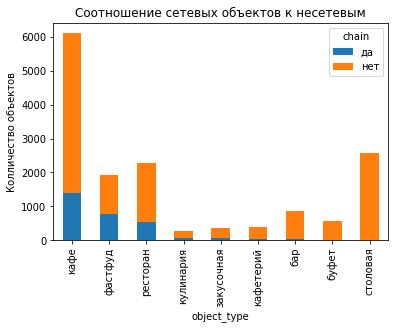

In [16]:
sett.plot(kind='bar',stacked=True)
plt.title('Соотношение сетевых объектов к несетевым')
plt.ylabel('Колличество объектов')
plt.show();

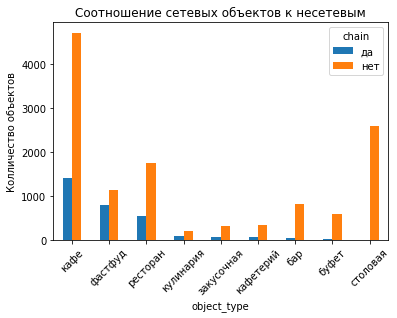

In [17]:
sett.plot(kind='bar', rot=45)
plt.title('Соотношение сетевых объектов к несетевым')
plt.ylabel('Колличество объектов');

Примечательно, что сетевые фастфуды незначительно отстают по колличеству от несетевых заведений быстрого питания. В целом ни один из объектов питания не является зоной влияния сетевиков. 

#### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

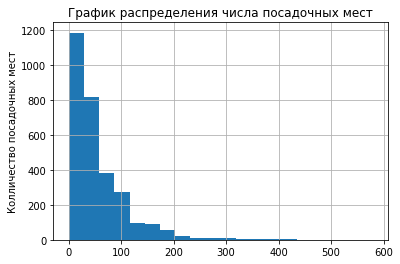

In [18]:
rest.query('chain == "да"')['number'].hist(bins=20)
plt.title('График распределения числа посадочных мест')
plt.ylabel('Колличество посадочных мест');

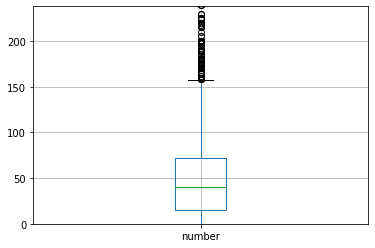

In [19]:
percentile_95 = np.percentile(rest.query('chain == "да"')['number'], 95)
plt.ylim(0, percentile_95*1.5)
rest.query('chain == "да"').boxplot(column = 'number')
plt.show()

Сетевые заведения имеют большее присутствие при меньшем колличестве посадочных мест по сравнению с иными заведениями общественного питания.

#### Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Построим графики

In [20]:
#найдем среднее колличество посадочных мест каждого объекта
data_seet = rest.pivot_table(index=['object_type'], values=['number'], aggfunc={'mean'})
data_seet

,number
,mean
object_type,
бар,43.494159
буфет,51.129915
закусочная,7.608333
кафе,39.716019
кафетерий,9.123116
кулинария,5.589744
ресторан,96.834136
столовая,130.246618


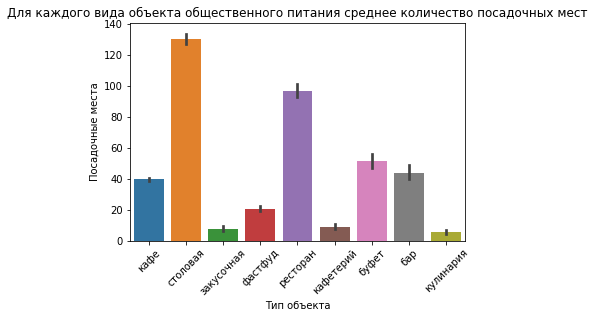

In [21]:
ax=sns.barplot(x='object_type', y='number', data=rest)
ax.set_xlabel('Тип объекта')
ax.set_ylabel('Посадочные места')
ax.set_title('Для каждого вида объекта общественного питания среднее количество посадочных мест')
plt.xticks(rotation=45)
plt.show();

In [22]:
def make_box_by_category(value=None, category=None, data=None, sort=False, sort_by_column=None, title=None):
    """
    value: боксплоты для каких значений строить
    category: группирующая переменная
    data: данные
    sort: как сортровать
    sort_by_column - по какому полю сортировать (либо то что в value, либо то что в category)
    """
    #сортировка по медиане
    tmp = \
        data\
        .groupby(category, as_index=False)\
        .agg({value:'median'})\
        .sort_values(by=sort_by_column, ascending=sort).reset_index()

    plt.figure(figsize=(9,6))
    sns.boxplot(x=category, y= value, data=data, showfliers=False, order=tmp[category].to_list(), 
                showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
    plt.title(title)
    plt.grid(True)
    plt.show()

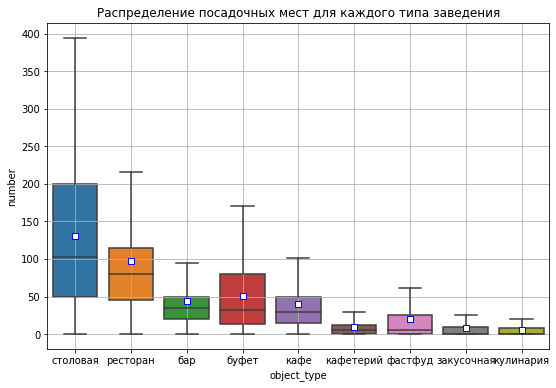

In [23]:
make_box_by_category(value='number', category='object_type', data=rest, sort=False, sort_by_column='number', \
                     title='Распределение посадочных мест для каждого типа заведения')

<hr style="border: 2px solid orange;" />

Максимальная Обеспеченность посадочными местами имеется в столовых и ресторанах. Значительная разница в посадочных метах пристуствует во всем ином сегменте общепита.

#### Выделим в отдельный столбец информацию об улице из столбца address

In [24]:
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

rest['streetname'] = rest['address'].str.extract(str_pat, flags=re.I)

In [25]:
rest

,id,object_name,chain,object_type,address,number,streetname
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,шоколадница,да,кафе,"город москва, 3-й крутицкий переулок, дом 18",50,3-й крутицкий переулок
15362,209264,шоколадница,да,кафе,"город москва, улица земляной вал, дом 33",10,улица земляной вал
15363,209186,шоколадница,да,кафе,"город москва, улица земляной вал, дом 33",20,улица земляной вал
15364,221900,шоколадница,да,кафе,"город москва, поселение московский, киевское ш...",36,киевское шоссе


#### Построим график топ-10 улиц по количеству объектов общественного питания.

In [26]:
#найдем самые насыщенные общепитом улицы
streets=rest.groupby('streetname').count().sort_values(by='object_type', ascending=False).head(10).reset_index()
streets

,streetname,id,object_name,chain,object_type,address,number
0,проспект мира,204,204,204,204,204,204
1,профсоюзная улица,182,182,182,182,182,182
2,ленинградский проспект,171,171,171,171,171,171
3,пресненская набережная,167,167,167,167,167,167
4,варшавское шоссе,164,164,164,164,164,164
5,ленинский проспект,147,147,147,147,147,147
6,проспект вернадского,132,132,132,132,132,132
7,кутузовский проспект,114,114,114,114,114,114
8,каширское шоссе,112,112,112,112,112,112
9,кировоградская улица,110,110,110,110,110,110


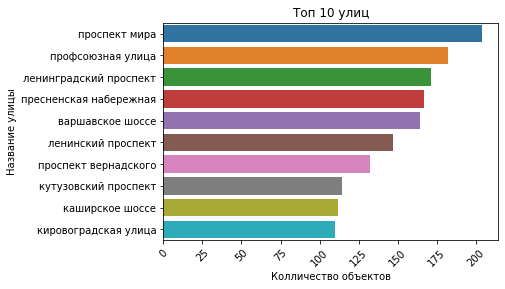

In [27]:
ax=sns.barplot(x='object_type', y='streetname', data=streets)
ax.set_xlabel('Колличество объектов')
ax.set_ylabel('Название улицы')
ax.set_title('Топ 10 улиц')
plt.xticks(rotation=45)
plt.show();

Соотнесем названия улиц с районами Москвы-для этого загрузим таблицу

In [28]:
from io import BytesIO
import requests
spreadsheet_id = '1_uLf8P88feokziY-gDnc0OcFVkUQbzSKJAvL2FXQX5Q'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [29]:
df['streetname'] = df['streetname'] .str.lower()

In [30]:
#добавим в нашу рабочую таблицу данные округа и района
rest=rest.merge(df, on='streetname')

In [31]:
rest.head(10)

,id,object_name,chain,object_type,address,number,streetname,areaid,okrug,area
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова,86,СВАО,Ярославский Район
1,193477,grill-house,нет,закусочная,"город москва, улица егора абакумова, дом 14а",0,улица егора абакумова,86,СВАО,Ярославский Район
2,196756,пекарня,нет,кафетерий,"город москва, улица егора абакумова, дом 14а",12,улица егора абакумова,86,СВАО,Ярославский Район
3,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина,18,ЦАО,Таганский район
4,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина,117,ЮВАО,Нижегородский район
5,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина,133,ЮЗАО,Район Южное Бутово
6,83942,кафе даиси,нет,кафе,"город москва, улица талалихина, дом 31а/2",78,улица талалихина,18,ЦАО,Таганский район
7,83942,кафе даиси,нет,кафе,"город москва, улица талалихина, дом 31а/2",78,улица талалихина,117,ЮВАО,Нижегородский район
8,83942,кафе даиси,нет,кафе,"город москва, улица талалихина, дом 31а/2",78,улица талалихина,133,ЮЗАО,Район Южное Бутово
9,24739,бар варвар,нет,кафе,"город москва, улица талалихина, дом 35",45,улица талалихина,18,ЦАО,Таганский район


In [32]:
# Найдем какому району соответствуют топ-10 улиц
streets=rest[['area']].join(streets)

In [33]:
streets.drop(streets.iloc[:, 2:8], inplace = True, axis = 1)
streets.head(10)

,area,streetname
0,Ярославский Район,проспект мира
1,Ярославский Район,профсоюзная улица
2,Ярославский Район,ленинградский проспект
3,Таганский район,пресненская набережная
4,Нижегородский район,варшавское шоссе
5,Район Южное Бутово,ленинский проспект
6,Таганский район,проспект вернадского
7,Нижегородский район,кутузовский проспект
8,Район Южное Бутово,каширское шоссе
9,Таганский район,кировоградская улица


Исходя из приведенных данных больше всего заведений в Ярославском районе, далее следует Таганский район, Нижегородский и Южное Бутово

#### Найдем число улиц с одним объектом общественного питания, в каких районах Москвы находятся эти улицы?

In [34]:
#сгруппировав по улицам-найдем где заведений не более 1
rest_count1=rest.groupby('streetname').count()
len(rest_count1.query('id == 1'))
rest_count1=rest_count1.query('id == 1').reset_index()

In [35]:
lostr=list(rest_count1['streetname'])
lostr=rest[rest['streetname'].isin(lostr)]
lostr

,id,object_name,chain,object_type,address,number,streetname,areaid,okrug,area
161,153644,американская лаборатория десертов,нет,кафе,"город москва, филипповский переулок, дом 15/5",20,филипповский переулок,12,ЦАО,Район Арбат
937,21214,столовая,нет,столовая,"город москва, бабаевская улица, дом 3",90,бабаевская улица,26,ВАО,Район Сокольники
1030,22139,хуанхэ,нет,ресторан,"город москва, 1-й балтийский переулок, дом 3/25",60,1-й балтийский переулок,54,САО,Район Аэропорт
1124,25833,азербайджан,нет,ресторан,"город москва, улица демьяна бедного, дом 4",180,улица демьяна бедного,92,СЗАО,Район Хорошево-Мневники
1467,150881,вгик,нет,столовая,"город москва, будайская улица, дом 3",45,будайская улица,81,СВАО,Район Ростокино
...,...,...,...,...,...,...,...,...,...,...
29253,213535,шаверма,нет,фастфуд,"город москва, 1-й силикатный проезд, дом 13",0,1-й силикатный проезд,92,СЗАО,Район Хорошево-Мневники
29254,208805,кафе,нет,кафе,"город москва, 3-й угрешский проезд, дом 8, стр...",15,3-й угрешский проезд,118,ЮВАО,Район Печатники
29255,211368,пацио пицца,нет,кафе,"город москва, улица линии октябрьской железной...",20,улица линии октябрьской железной дороги,67,САО,Тимирязевский Район
29260,214324,кадаши ( закрытый),нет,ресторан,"город москва, 2-й кадашёвский переулок, дом 16...",15,2-й кадашёвский переулок,21,ЦАО,Район Якиманка


In [36]:
lostr.groupby('area').count().sort_values('id').tail(10)

,id,object_name,chain,object_type,address,number,streetname,areaid,okrug
area,,,,,,,,,
Район Лефортово,11,11,11,11,11,11,11,11,11
Район Сокольники,11,11,11,11,11,11,11,11,11
Район Замоскворечье,12,12,12,12,12,12,12,12,12
Мещанский район,14,14,14,14,14,14,14,14,14
Пресненский район,15,15,15,15,15,15,15,15,15
Район Марьина роща,16,16,16,16,16,16,16,16,16
Тверской район,19,19,19,19,19,19,19,19,19
Район Хамовники,22,22,22,22,22,22,22,22,22
Басманный район,23,23,23,23,23,23,23,23,23


Наибольшее количество улиц с одним заведением располагается в районе Лефортово, Сокольники и Замоскворечье, что свидетельствует о небольшой насыщенности клиентской базы в данной локации.

#### Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

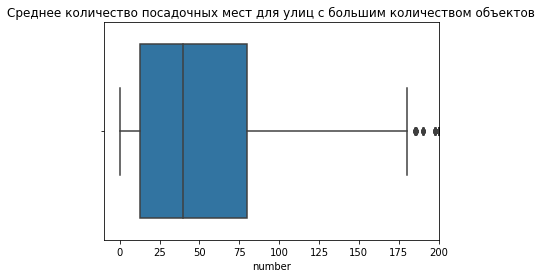

In [37]:
#рассмотрим на графике колличество посадочных мест на насыщенных улицах
streets_10=list(streets['streetname'])
data_streets=rest[rest['streetname'].isin(streets_10)]
ax=sns.boxplot(x=data_streets['number'])
ax.set_xlim(-10, 200)
ax.set_title('Среднее количество посадочных мест для улиц с большим количеством объектов')
plt.show();

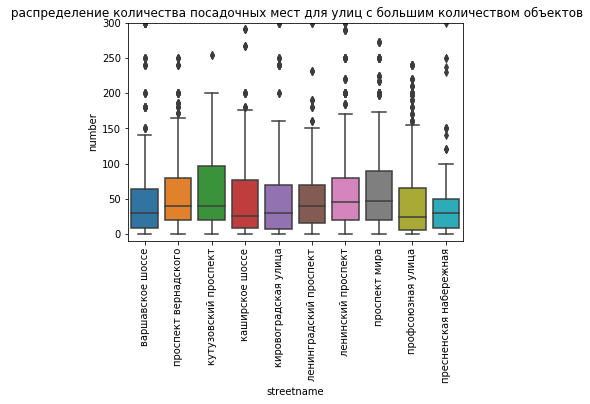

In [38]:
ax=sns.boxplot(x="streetname", y="number", data=data_streets, orient='v')
plt.xticks(rotation=90)
ax.set_ylim(-10, 300)
ax.set_title(' распределение количества посадочных мест для улиц с большим количеством объектов')
plt.show;

In [39]:
def make_box_by_category(value=None, street=None, data=None, sort=False, sort_by_column=None, title=None):
    #сортировка по медиане
    tmp = \
        data_streets\
        .groupby(street, as_index=False)\
        .agg({value:'median'})\
        .sort_values(by=sort_by_column, ascending=sort).reset_index()

    plt.figure(figsize=(12,6))
    sns.boxplot(x=street, y= value, data=data_streets, showfliers=False, order=tmp[street].to_list(), 
                showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
    plt.title(title)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

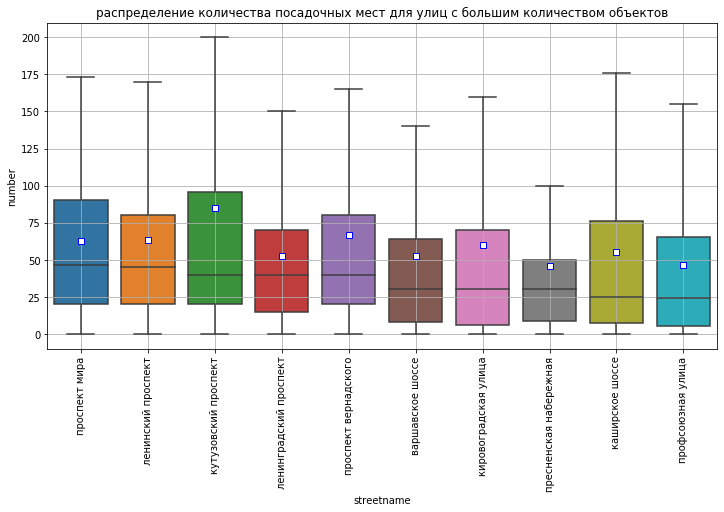

In [40]:
make_box_by_category(value='number', street='streetname', data=data_streets, sort=False, sort_by_column='number', \
                     title='распределение количества посадочных мест для улиц с большим количеством объектов')

Закономерность одна- места популярные-квадратные метры дорогие- посадочных мест мало

Наличие большого количества посадочных мест не является показателем популярности места общественного питания. В популярных местах локации малое количество посадочных мест не свидетельтсвует о непроходимости заведения. Скопление заведений в популярных местах позволяет владельцам заведений без ущерба посещаемости оптимизировать посадочные места.

# Общий вывод

Для открытия заведения общественного питания очень важно придерживаться имеющихся высокорентабельных мест дислокации. Поэтому напрашивается рекомендация использовать ноу-хау в виде обслуживания роботами в уже сформировавшихся районнах активности общепита. Учитывая,что популярность мест общепита не зависит от количества посадочных мест, то при выборе формата заведения стоит исключить массовые сферы в виде кафе и столовых.Остальные виды заведений представлены значительно меньшим количеством, что свидетельствует о превалируещем значении дислакации перед оригинальностью препеоднесения услуги.

## Презентация

https://docs.google.com/presentation/d/1ZjwK8wXYQ7WxJXrOrsbf8wgUWIVWy8LCsBGF0BVRrEU/edit?usp=sharing